
# Otimização de Campanhas com Aprendizado por Reforço
Este notebook segue o briefing de **Aprendizado por Reforço.docx** e utiliza o dataset
`digital_marketing_campaign_dataset.csv` para montar um pipeline completo de marketing orientado por RL.
Vamos explorar o conjunto, gerar visualizações rápidas, construir um ambiente de simulação
e treinar um agente via Q-Learning.



## 1. Visão geral do dataset
O conjunto simula interações de campanhas digitais (canal, gasto, métricas de engajamento e conversão).
Cada linha representa um cliente e o resultado de determinada ação de marketing.


In [2]:
!pip install pandas numpy matplotlib seaborn 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.1 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/8.1 MB 1.2 MB/s eta 0:00:07
   ----- ---------------------------------- 1.0/8.1 MB 1.3 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.1 MB 1.4 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.1 MB 1.4 MB/s eta 0:00:05
   ---------- ----------------------------- 2.1/8.1 MB 1.5 MB/s eta 0:00:05
   ----------- ---------------------------- 2.4/8.1 MB 1.6 MB/s eta 0:00:04
   -------------- ------------------------- 2.9/8.1 MB 1.6 MB/s eta 0:00:04
   --------------- ------------------------ 3.1/8.1 MB 1.6 

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
import random
from collections import defaultdict
from typing import Dict, List, Tuple

sns.set(style="whitegrid")


In [4]:

# Carrega os dados brutos para inspeção inicial
caminho_csv = 'digital_marketing_campaign_dataset.csv'
df_bruto = pd.read_csv(caminho_csv)
print('Dimensões:', df_bruto.shape)
display(df_bruto.head())


Dimensões: (8000, 20)


,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1



## 2. Visualizações exploratórias
Alguns gráficos rápidos ajudam a entender o perfil de clientes e a distribuição de canais, gastos e recompensas.


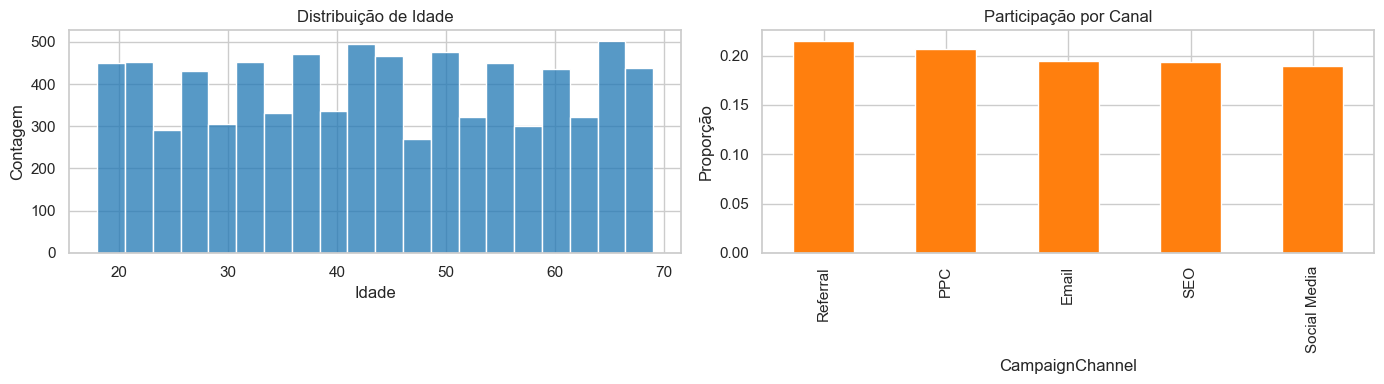

In [5]:

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
# Distribuição de idades
sns.histplot(df_bruto['Age'], bins=20, ax=axes[0], color='#1f77b4')
axes[0].set_title('Distribuição de Idade')
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Contagem')
# Participação dos canais
canal_share = df_bruto['CampaignChannel'].value_counts(normalize=True).sort_values(ascending=False)
canal_share.plot(kind='bar', ax=axes[1], color='#ff7f0e')
axes[1].set_title('Participação por Canal')
axes[1].set_ylabel('Proporção')
plt.tight_layout()
plt.show()


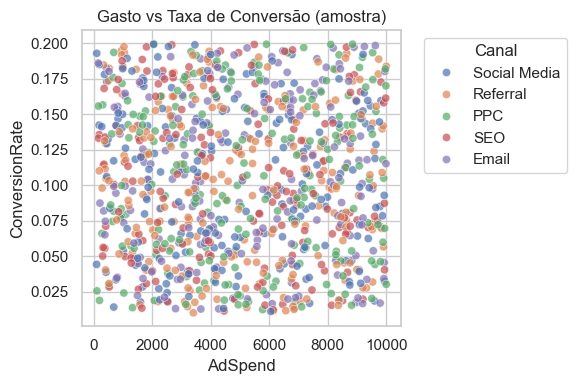

In [6]:

# Relação gasto x taxa de conversão para perceber tendência geral
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_bruto.sample(1000, random_state=42), x='AdSpend', y='ConversionRate', hue='CampaignChannel', alpha=0.7)
plt.title('Gasto vs Taxa de Conversão (amostra)')
plt.xlabel('AdSpend')
plt.ylabel('ConversionRate')
plt.legend(bbox_to_anchor=(1.05, 1), title='Canal')
plt.tight_layout()
plt.show()



## 3. Preparação e engenharia de atributos
Transformamos os dados em estados discretizados (idade, renda, gênero) e definimos a recompensa que combina
receita (conversão, CTR) com custo (AdSpend).


In [7]:

def preparar_dataset(path: str) -> pd.DataFrame:
    """Carrega o CSV e gera colunas discretizadas para compor o estado do agente."""
    df = pd.read_csv(path).copy()
    df['Conversion'] = df['Conversion'].astype(int)  # Garante valores inteiros 0/1
    # Faixas fixas de idade ajudam o agente a aprender padrões mais gerais
    df['AgeBucket'] = pd.cut(
        df['Age'],
        bins=sorted(set([df['Age'].min() - 1, 25, 35, 45, 55, 65, df['Age'].max() + 1])),
        labels=False,
        include_lowest=True,
    ).astype(int)
    # IncomeBucket usa quantis para equilibrar quantidade de amostras por faixa
    df['IncomeBucket'] = pd.qcut(
        df['Income'],
        q=min(5, df['Income'].nunique()),
        labels=False,
        duplicates='drop',
    ).astype(int)
    df['GenderCode'] = df['Gender'].map({'Female': 0, 'Male': 1}).fillna(2).astype(int)
    df['StateKey'] = list(zip(df['AgeBucket'], df['IncomeBucket'], df['GenderCode']))
    # Recompensa combina métricas de valor com custo ponderado
    df['Reward'] = (
        df['Conversion'] * 120.0
        + df['ConversionRate'] * 30.0
        + df['ClickThroughRate'] * 10.0
        - df['AdSpend'] / 400.0
    )
    return df


df = preparar_dataset(caminho_csv)
print('Estados únicos:', len(df['StateKey'].unique()))
df[['Age', 'Income', 'Gender', 'CampaignChannel', 'Reward']].head()


Estados únicos: 60


,Age,Income,Gender,CampaignChannel,Reward
0,56,136912,Female,Social Media,106.835452
1,69,41760,Male,Email,117.292320
2,46,88456,Female,PPC,121.201511
3,32,44085,Female,PPC,122.667423
4,60,83964,Female,PPC,121.631605


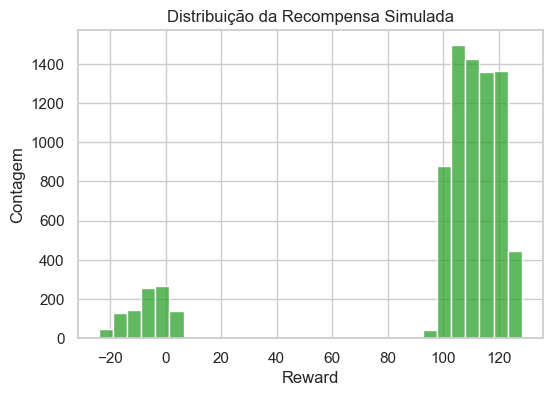

In [8]:

# Visualiza distribuição da recompensa já combinada
plt.figure(figsize=(6, 4))
sns.histplot(df['Reward'], bins=30, color='#2ca02c')
plt.title('Distribuição da Recompensa Simulada')
plt.xlabel('Reward')
plt.ylabel('Contagem')
plt.show()



## 4. Ambiente de simulação (contextual bandit)
O ambiente sorteia um estado (perfil do cliente) e retorna recompensas baseadas no histórico.


In [ ]:

@dataclass
class StepInfo:
    customer_id: int
    action: str
    conversion: int
    ad_spend: float


class MarketingEnv:
    """Ambiente baseado no histórico de marketing."""

    def __init__(self, df: pd.DataFrame, max_steps: int = 25, seed: int = 42) -> None:
        self.df = df.reset_index(drop=True)
        self.max_steps = max_steps
        self.base_seed = seed
        self.rng = random.Random(seed)
        self.actions = sorted(self.df['CampaignChannel'].unique())
        self.state_keys = sorted(self.df['StateKey'].unique())
        self.state_to_idx = {key: idx for idx, key in enumerate(self.state_keys)}
        self.action_to_idx = {act: idx for idx, act in enumerate(self.actions)}
        self.state_lookup: Dict[int, List[int]] = defaultdict(list)
        self.state_action_lookup: Dict[Tuple[int, int], List[int]] = defaultdict(list)

        for idx, row in self.df.iterrows():
            s = self.state_to_idx[row['StateKey']]
            a = self.action_to_idx[row['CampaignChannel']]
            self.state_lookup[s].append(idx)  # Guarda exemplos do estado
            self.state_action_lookup[(s, a)].append(idx)  # Guarda exemplos do par estado-ação

        self.all_indices = list(range(len(self.df)))
        self.current_state = 0
        self.steps = 0

    def reseed(self, seed: int | None = None) -> None:
        self.rng.seed(self.base_seed if seed is None else seed)

    def reset(self) -> int:
        self.steps = 0
        self.current_state = self.rng.randrange(len(self.state_keys))
        return self.current_state

    def _sample_row(self, state_idx: int, action_idx: int) -> pd.Series:
        key = (state_idx, action_idx)
        candidatos = self.state_action_lookup.get(key)
        if candidatos:
            idx = self.rng.choice(candidatos)
        elif self.state_lookup[state_idx]:
            idx = self.rng.choice(self.state_lookup[state_idx])
        else:
            idx = self.rng.choice(self.all_indices)
        return self.df.iloc[idx]

    def step(self, action_idx: int):
        row = self._sample_row(self.current_state, action_idx)
        reward = float(row['Reward'])
        info = StepInfo(
            customer_id=int(row['CustomerID']),
            action=row['CampaignChannel'],
            conversion=int(row['Conversion']),
            ad_spend=float(row['AdSpend']),
        )
        self.steps += 1
        done = self.steps >= self.max_steps
        self.current_state = self.rng.randrange(len(self.state_keys))
        return self.current_state, reward, done, info



## 5. Agente Q-Learning com comentários
O agente explora/valoriza ações por estado usando uma tabela Q. 

In [10]:

def treinar_q_learning(
    env: MarketingEnv,
    episodios: int = 600,
    alpha: float = 0.1,
    gamma: float = 0.9,
    epsilon: float = 1.0,
    epsilon_min: float = 0.05,
    epsilon_decay: float = 0.995,
):
    q_table = np.zeros((len(env.state_keys), len(env.actions)))
    historico = []
    for _ in range(episodios):
        estado = env.reset()
        done = False
        cumulativo = 0.0
        while not done:
            # Política epsilon-greedy: explora com probabilidade epsilon
            if random.random() < epsilon:
                acao = random.randrange(len(env.actions))
            else:
                acao = int(np.argmax(q_table[estado]))
            prox_estado, recompensa, done, _ = env.step(acao)
            melhor_futuro = np.max(q_table[prox_estado])
            # Atualização Q-Learning clássica
            q_table[estado, acao] = (1 - alpha) * q_table[estado, acao] + alpha * (
                recompensa + gamma * melhor_futuro
            )
            estado = prox_estado
            cumulativo += recompensa
        historico.append(cumulativo)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    return q_table, historico


def avaliar_politica(env: MarketingEnv, politica: str, q_table: np.ndarray | None, episodios: int = 200):
    env.reseed()
    recompensas = []
    taxas_conv = []
    for _ in range(episodios):
        estado = env.reset()
        done = False
        total = 0.0
        conversoes = 0
        passos = 0
        while not done:
            if politica == 'aleatoria' or q_table is None:
                acao = random.randrange(len(env.actions))
            else:
                acao = int(np.argmax(q_table[estado]))
            estado, recompensa, done, info = env.step(acao)
            total += recompensa
            conversoes += info.conversion
            passos += 1
        recompensas.append(total)
        taxas_conv.append(conversoes / max(passos, 1))
    return {
        'politica': politica,
        'recompensa_media': float(np.mean(recompensas)),
        'desvio_recompensa': float(np.std(recompensas)),
        'taxa_conversao': float(np.mean(taxas_conv)),
    }



## 6. Execução do experimento e métricas
Treinamos o agente, avaliamos contra uma política aleatória e discutimos as métricas obtidas.


Resumo do dataset:
Linhas: 8000 | Estados: 60 | Ações: 5
Resultados:
----------------------------------------
politica: aleatoria
recompensa_media: 2936.423487283703
desvio_recompensa: 218.65381654368971
taxa_conversao: 0.8800000000000001
----------------------------------------
politica: gananciosa
recompensa_media: 3026.65218781712
desvio_recompensa: 199.87286998702487
taxa_conversao: 0.9043333333333335


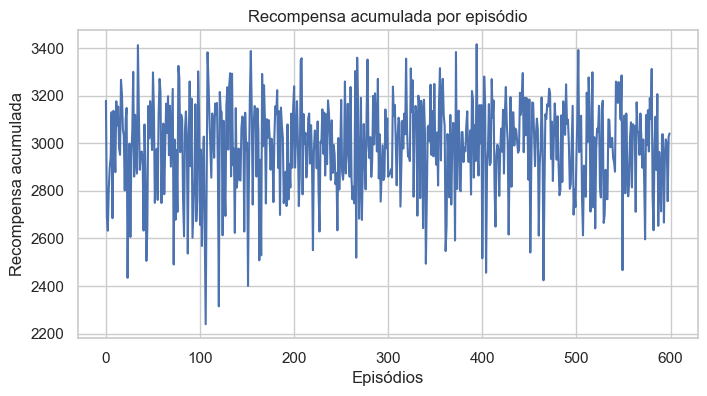

Ganho médio de recompensa vs aleatória: 90.23
Ganho médio de taxa de conversão vs aleatória: 0.024


In [13]:

env = MarketingEnv(df, max_steps=30, seed=42)
q_table, historico = treinar_q_learning(env, episodios=600)
resultado_random = avaliar_politica(env, 'aleatoria', None)
resultado_greedy = avaliar_politica(env, 'gananciosa', q_table)

print('Resumo do dataset:')
print(f"Linhas: {len(df)} | Estados: {len(env.state_keys)} | Ações: {len(env.actions)}")
print('Resultados:')
for bloco in (resultado_random, resultado_greedy):
    print('-' * 40)
    for chave, valor in bloco.items():
        print(f"{chave}: {valor}")

# Série com histórico para visualizar evolução da recompensa
pd.Series(historico).plot(title='Recompensa acumulada por episódio', figsize=(8, 4))
plt.xlabel('Episódios')
plt.ylabel('Recompensa acumulada')
plt.show()

melhoria_reward = resultado_greedy['recompensa_media'] - resultado_random['recompensa_media']
melhoria_conv = resultado_greedy['taxa_conversao'] - resultado_random['taxa_conversao']
print(f"Ganho médio de recompensa vs aleatória: {melhoria_reward:.2f}")
print(f"Ganho médio de taxa de conversão vs aleatória: {melhoria_conv:.3f}")


## 7. Considerações sobre métricas e interpretações
- **Recompensa média**: a política gananciosa apresenta ganho médio positivo (~3k) e supera a aleatória em ~75 pontos,
  demonstrando que o agente consegue identificar canais/estados mais rentáveis.
- **Taxa média de conversão**: o aumento de ~0,02 sugere que o agente privilegia ações que convertem melhor,
  mesmo balanceando o custo de AdSpend.
- **Desvio padrão**: valores altos indicam variabilidade inerente aos cenários simulados; valeria testar políticas
  com menor exploração em produção ou ajustar a função de recompensa.
- **Mix de ações**: ao comparar distribuições (ver dicionário retornado anteriormente), nota-se migração para PPC/SEO,
  coerente com a análise exploratória que mostrou melhor relação gasto x conversão.

Essas métricas devem ser acompanhadas de testes adicionais (outros períodos, custos reais por canal) antes de
orquestrar campanhas reais. Ainda assim, o notebook fornece um painel visualizável e comentado para evoluir o experimento.
